In [1]:
import copy
import glob
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import scipy.stats
import tqdm
import warnings

In [2]:
import yt
import trident
import unyt

In [3]:
import kalepy as kale

In [4]:
import trove
import verdict

In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use( '/Users/zhafen/repos/clean-bold/clean-bold.mplstyle' )
import palettable
import matplotlib.patheffects as path_effects

In [6]:
import helpers

# Parameters

In [7]:
pm = {
    # Analysis 
    'prop_keys': [ 'vlos', 'T', 'nH', 'Z', 'x' ],
    'vel_prop_keys': [ 'vlos', 'T', 'nH', 'Z', 'NHI' ],
    'broaden_models': False,
    '1D_dist_estimation': 'kde',
    '1D_dist_estimation_data': 'histogram',
    '2D_dist_estimation': 'histogram',
    
    # Plotting Choices
    'smooth_2D_dist': 0.5,
    'upsample_2D_dist': 3,
    '2D_dist_data_display': 'histogram',
    'contour_levels': [ 68, ],
    'contour_linewidths': [ 3, ],
    'show_plots_in_nb': True,
}

In [8]:
# Load parameters
pm = trove.link_params_to_config(
    '/Users/zhafen/analysis/cgm_modeling_challenge/sample2.trove',
    script_id = 'nb.2',
    variation = 'high-z',
    global_variation = 'unweighted',
    **pm
)

In [9]:
redshift = pm['redshift']
prop_keys = pm['prop_keys']
n_sample_turb = pm['n_sample_turb']

In [10]:
data_dir = pm['data_dir']
base_data_dir = pm['base_data_dir']
ray_dir = os.path.join( base_data_dir, 'rays' )
results_dir = os.path.join( pm['results_dir'], pm['variation'] )

In [11]:
calc_correlations = False

## Analysis

In [12]:
correlation_coefficients = {
    'one-sided': {},
    'log one-sided': { 'logscale': True, 'subtract_mean': True },
    'two-sided': { 'one_sided': False, },
    'linear': { 'one_sided': False, 'subtract_mean': True },
    'log': { 'logscale': True, 'one_sided': False, 'subtract_mean': True },
}

In [13]:
lims = helpers.lims
lims_1D = helpers.lims_1D
autolims = helpers.autolims

In [14]:
dvs = {
    'vlos': 5.,
    'T': 0.05,
    'nH': 0.05,
    'Z': 0.05,
    'NHI': 0.05,
}

In [15]:
logscale = helpers.logscale

In [16]:
bar_format = pm['bar_format']

## Plotting

In [17]:
variation_plotting_params = {
    'original': {
        'color': helpers.blinded_color,
    },
    'high-z': {
        'color': helpers.revised_color,
    },
}

In [18]:
labels = helpers.property_labels
labels_1D = {}
for key, item in labels.items():
    labels_1D[key] = helpers.property_labels_1D( key, pm['weighting'] )
r_labels = helpers.correlation_coefficient_property_labels

In [19]:
correlation_markers = {
    'one-sided': '^',
    'log one-sided': '^',
    'two-sided': 'D',
    'linear': 'o',
    'log': 'o',
}
correlation_sizes = {
    'one-sided': 100,
    'log one-sided': 100,
    'two-sided': 80,
    'linear': 100,
    'log': 100,
}
correlations_plotted = [ 'linear', 'log' ]

In [20]:
mosaic = [
    [ 'vlos', 'legend', '.', '.', '.' ],
    [ 'T_vlos', 'T', '.', '.', '.' ],
    [ 'nH_vlos', 'nH_T', 'nH', '.', '.' ],
    [ 'Z_vlos', 'Z_T', 'Z_nH', 'Z', '.' ],
    [ 'x_vlos', 'x_T', 'x_nH', 'x_Z', 'x' ],
]

In [21]:
panel_length = 4.

In [22]:
cmap = palettable.cartocolors.qualitative.Safe_10.mpl_colors[2:]
corr_cmap = palettable.cartocolors.diverging.Temps_2_r.mpl_colormap

In [23]:
corr_norm = matplotlib.colors.Normalize( vmin=0, vmax=1 )

In [24]:
def one_color_linear_cmap( color, name, f_white=0.95, f_saturated=1.0, ):
    '''A function that turns a single color into linear colormap that
    goes from a color that is whiter than the original color to a color
    that is more saturated than the original color.
    '''
    
    color_hsv = matplotlib.colors.rgb_to_hsv( color )
    start_color_hsv = copy.copy( color_hsv )
    
    start_color_hsv = copy.copy( color_hsv )
    start_color_hsv[1] -= f_white * start_color_hsv[1]
    start_color_hsv[2] += f_white * ( 1. - start_color_hsv[2] )
    start_color = matplotlib.colors.hsv_to_rgb( start_color_hsv )
    
    end_color_hsv = copy.copy( color_hsv )
    end_color_hsv[1] += f_saturated * ( 1. - end_color_hsv[1] )
    end_color = matplotlib.colors.hsv_to_rgb( end_color_hsv )
    
    return matplotlib.colors.LinearSegmentedColormap.from_list( name, [ start_color, end_color ] )

In [25]:
color_estimated = variation_plotting_params[pm['variation']]['color']
color_data = ( 0, 0, 0 )
cmap_estimated = one_color_linear_cmap( color_estimated, 'estimated' )
cmap_data = one_color_linear_cmap( color_data, 'source' )
cmap_data = matplotlib.colors.LinearSegmentedColormap.from_list( 'source', [ 'w', color_data ] )

In [26]:
public_label = pm['public_label']

In [27]:
contour_levels = pm['contour_levels']
contour_linewidths = pm['contour_linewidths']

# Tools

In [28]:
ldb = trident.LineDatabase(None)

read_sets: Using set file -- 
  /Users/zhafen/repos/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [29]:
def zeff_to_vel( zeff ):
    
    ainv2 = ( ( 1. + zeff ) / ( 1. + redshift ) )**2.
    
    v_div_c = ( ainv2 - 1. ) / ( ainv2 + 1. )
    return ( v_div_c * unyt.c ).to( 'km/s' ).value

In [30]:
unyt.Zsun

Zsun

# Load Data

## Estimated

In [31]:
estimated_data_formats = {
    'v0': {
        'col_names': [ 'prob', 'likelihood', 'Z', 'nH', 'T', 'NHI', 'bturb', 'z', ],
        'col_units':  [ 1., 1., unyt.Zsun, unyt.cm**-3, unyt.K, unyt.cm**-2, unyt.km / unyt.s, 1. ],
        'vlos_from_z': True,
        'dir_structure': 'one_dir_per_sl',
    },
    'v1': {
        'col_names': [ 'prob', 'likelihood', 'Z', 'nH', 'T', 'NHI', 'vlos', 'bturb', 'thickness' ],
        'col_units':  [ 1., -0.5, unyt.Zsun, unyt.cm**-3, unyt.K, unyt.cm**-2, unyt.km / unyt.s,  unyt.km / unyt.s, 1. ],
        'vlos_from_z': False,
        'dir_structure': 'one_dir_per_sl',
    },
    'v2': {
        'raw_col_names': [ 'Z', 'nH', 'T', 'NHI', 'bturb', 'L', 'V', 'btherm', 'btherm_HI' ],
        'col_names': [ 'Z', 'nH', 'T', 'NHI', 'bturb', 'L', 'vlos', 'btherm', 'btherm_HI' ],
        'col_units':  [ unyt.Zsun, unyt.cm**-3, unyt.K, unyt.cm**-2, unyt.km / unyt.s, unyt.kpc, unyt.km / unyt.s, unyt.km / unyt.s, unyt.km / unyt.s, ],
        'vlos_from_z': False,
        'dir_structure': 'one_dir',
    },
}

In [32]:
estimated_data_format = estimated_data_formats[pm['estimated_data_format']]
col_names = copy.copy( estimated_data_format['col_names'] )
col_units = copy.copy( estimated_data_format['col_units'] )
if estimated_data_format['vlos_from_z']:
    col_names.append( 'vlos' )
    col_units.append( unyt.km / unyt.s )

In [33]:
sls = []
sl_fps = []
mle_fps = []
other_fps = []
sl_datas = []
mle_datas = []

In [34]:
# For the old data format
if estimated_data_format['dir_structure'] == 'one_dir_per_sl':
    for sl_fp in glob.glob( os.path.join( results_dir, '*' ) ):

        if not os.path.isdir( sl_fp ):
            other_files.append( sl_fp )
            continue

        i = os.path.split( sl_fp )[-1]

        if int( i ) in pm['selected_sightlines']:

            sl_fps.append( sl_fp )
            sls.append( i )
            
        sl_data = {}
        for component_fp in glob.glob( os.path.join( sl_fp, '*' ) ):
            component_key = os.path.splitext( os.path.split( component_fp )[-1] )[0]
            sl_data[component_key] = pd.read_csv( component_fp, sep=' ', names=col_names )
        sl_datas.append( sl_data )
            
    mle_data_found = False

In [35]:
# For the new format data
if estimated_data_format['dir_structure'] == 'one_dir':
    
    for fp in glob.glob( os.path.join( results_dir, '*' ) ):
        
        fn = os.path.split( fp )[-1]
        
        if os.path.splitext( fn )[-1] != '.pkl':
            other_fps.append( fp )
            continue
            
        i, ext = fn.split( '_' )
        
        if int( i ) not in pm['selected_sightlines']:
            continue
            
        # Load and do initial processing of full SL data
        if ext == 'full.pkl':
                       
            # Load the file
            with open( fp, 'rb' ) as f:
                sl_raw_data = pickle.load( f )
                
            # Extract the data
            sl_data = {}
            for column_name in sl_raw_data.columns:

                # Get component
                ion = '_'.join( column_name.split( '_' )[:2] )

                # Don't re-add
                if ion in sl_data.keys():
                    continue

                # Store
                ion_col_names = [ '{}_{}'.format( ion, _ ) for _ in estimated_data_format['raw_col_names'] ]    
                sl_data[ion] = sl_raw_data[ion_col_names]

                # Rename
                sl_data[ion].columns=estimated_data_format['col_names']
            
            sl_datas.append( sl_data )
            sl_fps.append( fp )
            sls.append( i )
                
        elif ext == 'mle.pkl':
            mle_fps.append( fp )
            
mle_data_found = len( mle_datas ) > 0

In [36]:
# Process data
sl_useds = []
sl_compkeys = []
sl_stackeds = []
model_weightss = []
stacked_weightss = []
total_weightss = []
median_NHIs = []
for i, sl in enumerate( sls ):
    
    sl_fp = sl_fps[i]
    
    # Get text files

    sl_data= sl_datas[i]
        
    # Add LOS velocity and reformat
    for component_key, df in sl_data.items():

        # Reformat
        new_entry = {}
        for name in col_names:
            values = unyt.unyt_array( df[name].values )
            if name in [ 'nH', 'T', 'Z', 'NHI', 'thickness' ]:
                new_entry[name] = 10.**values
            else:
                new_entry[name] = values

        # Add LOS velocity
        if estimated_data_format['vlos_from_z']:
            new_entry['vlos'] = zeff_to_vel( df['z'].values )

        # Set up units
        for j, name in enumerate( col_names ):
            new_entry[name] *= col_units[j]

        sl_data[component_key] = new_entry
        
    # Turn samples into a list
    keys = sorted( list( sl_data.keys() ) )
    sl_formatted = {}
    for name in col_names:
        sl_formatted[name] = [ sl_data[_][name] for _ in keys ]

    # Generate estimated sample to plot ("generate" because we're sampling the doppler broadening)
    if pm['broaden_models']:
        sl_tiled = {}
        for name in col_names:
            sl_tiled[name] = []

        for j, vlos_j in enumerate( tqdm.tqdm( sl_formatted['vlos'], bar_format=bar_format ) ):
            sample_dist = scipy.stats.norm( loc=vlos_j, scale=sl_formatted['bturb'][j]/np.sqrt( 2. ) )
            sampled_values = sample_dist.rvs( ( n_sample_turb, vlos_j.size ) )

            for name in col_names:
                if name != 'vlos':
                    arr_tiled = np.hstack( np.tile( sl_formatted[name][j], ( n_sample_turb, 1 ),  ) )
                else:
                    arr_tiled = np.hstack( sampled_values )

                arr_tiled *= sl_formatted[name][j].units

                sl_tiled[name].append( arr_tiled )

        sl_used = sl_tiled
    else:
        sl_used = sl_formatted

    # Minimum weighting is to make sure no component is overweighted due to number of samples
    n_samples_max = np.max([ _.size for _ in sl_used['nH'] ])
    if pm['weighting'] is None:
        model_weights = [ np.full( _.size, n_samples_max / _.size ) for _ in sl_used['nH'] ]
    else:
        model_weights = [ np.full( _.size, np.nanmedian( _ ) * n_samples_max / _.size ) for _ in sl_used[pm['weighting']] ]
    model_weightss.append( model_weights )
    stacked_weightss.append( np.hstack( model_weights ) )
    total_weightss.append( np.array([ _.sum() for _ in model_weights ]) )
    median_NHIs.append( np.array([ np.nanmedian( _ ) for _ in sl_used['NHI'] ]) )

    sl_stacked = {}
    for key, item in sl_used.items():
        sl_stacked[key] = np.hstack( item ) * item[0].units
    
    sl_datas.append( sl_data )
    sl_useds.append( sl_used )
    sl_compkeys.append( keys )
    sl_stackeds.append( sl_stacked )

## Actual

In [37]:
# Get rays
ray_fps = [ os.path.join( ray_dir, 'ray_{}.h5'.format( _[1:] ) ) for _ in sls ]
rays = [ yt.load( _ ) for _ in ray_fps ]

yt : [INFO     ] 2023-03-25 18:53:06,638 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-03-25 18:53:06,640 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-03-25 18:53:06,641 Parameters: domain_left_edge          = [0. 0. 0.] kpc
yt : [INFO     ] 2023-03-25 18:53:06,642 Parameters: domain_right_edge         = [95.7322 95.7322 95.7322] kpc
yt : [INFO     ] 2023-03-25 18:53:06,643 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2023-03-25 18:53:06,709 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-03-25 18:53:06,711 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-03-25 18:53:06,712 Parameters: domain_left_edge          = [0. 0. 0.] kpc
yt : [INFO     ] 2023-03-25 18:53:06,713 Parameters: domain_right_edge         = [95.7322 95.7322 95.7322] kpc
yt : [INFO     ] 2023-03-25 18:53:06,714 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2023-03-25 18:53:06,778 Parameters: current_time   

In [38]:
ray_datas = []
ray_weights = []
for ray in rays:
    # Ray properties
    trident.add_ion_fields(ray, ions=[ 'H I', ], line_database=ldb)
    den = ray.r[('gas', 'number_density')] * 0.75
    ray_data = {
        'nH': den,
        'NH': ( den * ray.r[('gas', 'dl')] ),
        'NHI': ray.r[('gas', 'H_p0_number_density')] * ray.r[('gas', 'dl')],
        'z': ray.r[('gas', 'redshift_eff')],
        'T': ray.r[('gas', 'temperature')],
        'Z': ray.r[('gas', 'metallicity')],
        'x': ray.r[('gas', 'z')] - 48. * unyt.kpc,
    }
    ray_data['vlos'] = zeff_to_vel( ray_data['z'] ) * unyt.km / unyt.s
    
    if pm['sim_weighting'] is None:
        weights = np.ones( ray_data['NH'].shape )
    else:
        weights = copy.copy( ray_data[pm['sim_weighting']].value )
        weights[np.isclose(weights,0.)] = np.nan
    
    ray_datas.append( ray_data )
    ray_weights.append( weights )

yt : [INFO     ] 2023-03-25 18:53:07,264 Allocating for 1.024e+03 particles


## Bins and Limits

In [39]:
all_binss = []
all_dxs = []
all_centerss = []
for i, ray_data in enumerate( tqdm.tqdm( ray_datas, bar_format=bar_format ) ):
    
    sl_stacked = sl_stackeds[i]

    # Make bins, dx, and centers
    all_bins = {}
    all_dx = {}
    all_centers = {}
    for n_bins_key in [ 'n_bins_1D', 'n_bins_2D', 'n_bins_data_1D', 'n_bins_data_2D', 'n_bins_convolve' ]:
        n_bins = pm[n_bins_key]
        bins = {}
        for key, item in lims.items():
            if autolims[key]:
                if key in sl_stacked:
                    values_for_limits = np.hstack([ sl_stacked[key], ray_data[key] ])
                else:
                    values_for_limits = ray_data[key].value
                low = np.nanmin(values_for_limits)
                high = np.nanmax(values_for_limits)
            else:
                low = item[0]
                high = item[1]
            if logscale[key]:
                bins[key] = np.logspace( np.log10( low ), np.log10( high ), n_bins )
            else:
                bins[key] = np.linspace( low, high, n_bins )

            bins[key] *= ray_data[key].units
        all_bins[n_bins_key] = bins

        dx = {}
        for key, bins_j in bins.items():
            if logscale[key]:
                dx[key] = np.log10( bins_j[1] ) - np.log10( bins_j[0] )
            else:
                dx[key] = float( ( bins_j[1] - bins_j[0] ).value )
        all_dx[n_bins_key] = dx

        centers = {}
        for key, bins_j in bins.items():

            if logscale[key]:
                bins_j = np.log10( bins_j )

            centers[key] = bins_j[:-1] + 0.5 * np.diff( bins_j )

            if logscale[key]:
                centers[key] = 10.**centers[key]
        all_centers[n_bins_key] = centers
        
    all_binss.append( all_bins )
    all_dxs.append( all_dx )
    all_centerss.append( all_centers )

     100%|██████████| 10/10 [00:00<00:00, 274.72it/s]


# Comparison Metrics

## Calculation

In [40]:
def calc_correlation( found, actual, logscale=False, one_sided=True, subtract_mean=False, ):
    '''Calculate the correlation coefficient.
    
    Args:
        found (array-like):
            estimated data.
            
        actual (array-like):
            Actual data.
            
        logscale (bool):
            If True, do comparison after putting input arrays in logspace.
            
        one_sided (bool):
            If True, normalize by actual.sum()**2, not sqrt( found.sum()**2 * actual.sum()**2 ).
            
        subtract_mean (bool):
            If True, subtract the mean prior to calculating correlations.
    '''
    
    found = copy.copy( found )
    actual = copy.copy( actual )
    
    # Logscale
    if logscale:
        found = np.log10( found )
        actual = np.log10( actual )
    
    # Identify valid values
    found_valid = np.isfinite( found )
    actual_valid = np.isfinite( actual )
    is_valid = found_valid & actual_valid
    
    if subtract_mean:
        found -= np.mean( found[found_valid] )
        actual -= np.mean( actual[actual_valid] )
    
    # Calculate the correlation
    top = found * actual
    top_sum = top[is_valid].sum()
    
    # Calculate the normalization
    bottom = actual**2.
    bottom_sum = bottom[actual_valid].sum()
    if not one_sided:
        bottom_found = found**2.
        bottom_sum_found = bottom_found[found_valid].sum()
        bottom_sum = np.sqrt( bottom_sum * bottom_sum_found )
    
    return top_sum / bottom_sum

In [41]:
if calc_correlations:
    correlations = verdict.Dict({})
    for i, sl in enumerate( tqdm.tqdm( sls, bar_format=bar_format ) ):

        # Setup correlation matrix
        for c_key in correlation_coefficients.keys():
            correlation_matrix = np.full( ( len( prop_keys ), len( prop_keys ) ), np.nan )
            correlations.setitem( c_key, correlation_matrix, 'matrix', sls[i] )
            correlations.setitem( c_key, prop_keys, 'matrix properties', sls[i] )

        # Get ray data
        ray_data = ray_datas[i]
        weights = ray_weights[i]

        # Get estimated data
        sl_stacked = sl_stackeds[i]
        model_weights = model_weightss[i]
        stacked_weights = stacked_weightss[i]

        # Get bins
        bins = all_binss[i]['n_bins_convolve']
        dx = all_dxs[i]['n_bins_convolve']
        centers = all_centerss[i]['n_bins_convolve']

        # Format for calculating distributions
        ray_data_histdd = []
        sl_stacked_histdd = []
        bins_histdd = []
        for key in prop_keys:

            arr_estimated = sl_stacked[key].value
            arr = ray_data[key].value
            bins_key = bins[key]

            if logscale[key]:
                arr_estimated = np.log10( arr_estimated )
                arr = np.log10( arr )
                bins_key = np.log10( bins_key )

            sl_stacked_histdd.append( arr_estimated )
            ray_data_histdd.append( arr )
            bins_histdd.append( bins_key )

        sl_stacked_histdd = np.array( sl_stacked_histdd ).transpose()
        ray_data_histdd = np.array( ray_data_histdd ).transpose()
        bins_histdd = np.array( bins_histdd )

        # Calculate ND distribution for ray data
        ray_dist_dd, bins_dd = np.histogramdd(
            ray_data_histdd,
            bins = bins_histdd,
            weights = weights,
        )
        ray_dist_dd /= ray_dist_dd.sum()

        # Calculate ND distribution for estimated data
        estimated_dist_dd, bins_dd = np.histogramdd(
            sl_stacked_histdd,
            bins = bins_histdd,
            weights = stacked_weights,
        )
        estimated_dist_dd /= estimated_dist_dd.sum()

        # Calculate net correlation coefficients
        for c_key, kwargs in correlation_coefficients.items():
            corr_ndim = calc_correlation( estimated_dist_dd, ray_dist_dd, **kwargs )
            correlations.setitem( c_key, corr_ndim, 'ndim', sls[i] )

        # Calculate correlation coefficients for each property
        for j, x_key in enumerate( prop_keys ):
            for k, y_key in enumerate( prop_keys ):

                # Avoid duplicates
                if k < j:
                    continue

                ray_dist_2d, _, _ = np.histogram2d(
                    ray_data_histdd[:,j],
                    ray_data_histdd[:,k],
                    bins = [ bins_histdd[j], bins_histdd[k] ],
                    weights = weights,
                )
                ray_dist_2d /= ray_dist_2d.sum()

                estimated_dist_2d, _, _ = np.histogram2d(
                    sl_stacked_histdd[:,j],
                    sl_stacked_histdd[:,k],
                    bins = [ bins_histdd[j], bins_histdd[k] ],
                    weights = stacked_weights,
                )
                estimated_dist_2d /= estimated_dist_2d.sum()

                for c_key, kwargs in correlation_coefficients.items():

                    correlation_matrix = correlations[c_key]['matrix'][sls[i]]
                    correlation_matrix[j,k] = calc_correlation( estimated_dist_2d, ray_dist_2d, **kwargs )
                    correlation_matrix[k,j] = correlation_matrix[j,k]
                    correlations[c_key]['matrix'][sls[i]] = correlation_matrix


In [42]:
# Save data
if calc_correlations & ( pm['global_variation'] == '' ):
    correlations_fp = os.path.join( pm['polished_data_dir'], 'correlation_coefficients.h5' )
    correlations_all = verdict.Dict.from_hdf5( correlations_fp, create_nonexistent=True )
    correlations_all[public_label] = correlations
    correlations_all.to_hdf5( correlations_fp )

## Corner Plot

In [43]:
if calc_correlations:
    # Setup Figure
    n_cols = len( prop_keys )
    fig = plt.figure( figsize=( panel_length*n_cols, panel_length*n_cols ), facecolor='w' )
    ax_dict = fig.subplot_mosaic(
        mosaic,
        gridspec_kw = { 'hspace': 0.1, 'wspace': 0.1 },
    )

    # Loop through all properties
    for j, x_key in enumerate( tqdm.tqdm( prop_keys, bar_format=bar_format ) ):
        for k, y_key in enumerate( prop_keys ):

            # Avoid duplicates
            if k < j:
                continue

            # Comparison to ndim
            if j == k:
                ax = ax_dict[x_key]
                subplotspec = ax.get_subplotspec()

                x_label = r_labels[x_key]
                y_label = r_labels['all']

                for c_key in correlations_plotted:
                    c_params = correlation_coefficients[c_key]
                    facecolors = 'k'
                    if 'logscale' in c_params:
                        if c_params['logscale']:
                            facecolors = 'none'

                    scatter = ax.scatter(
                        correlations[c_key]['matrix'].array()[:,j,k],
                        correlations[c_key]['ndim'].array(),
                        label = c_key,
                        edgecolors = 'k',
                        facecolors = facecolors,
                        marker = correlation_markers[c_key],
                        s = correlation_sizes[c_key],
                        linewidth = 2,
                    )

                if x_key in [ 'T', 'nH', 'Z' ]:
                    ax.yaxis.set_label_position( 'right' )
                    ax.set_ylabel( y_label, fontsize=16 )

                ax.tick_params(
                    which = 'both',
                    right = True,
                    labelright = True,
                )

            # 2D comparisons
            else:
                try:
                    ax = ax_dict['{}_{}'.format( x_key, y_key )]
                except KeyError:
                    ax = ax_dict['{}_{}'.format( y_key, x_key )]
                subplotspec = ax.get_subplotspec()

                x_label = r_labels[x_key]
                y_label = r_labels[y_key]

                for c_key in correlations_plotted:
                    colors = correlations[c_key]['matrix'].array()[:,j,k]
                    colors = corr_cmap( corr_norm( colors ) )

                    # Choose facecolor
                    facecolors = colors
                    c_params = correlation_coefficients[c_key]  
                    if 'logscale' in c_params:
                        if c_params['logscale']:
                            facecolors = 'None'

                    ax.scatter(
                        correlations[c_key]['matrix'].array()[:,j,j],
                        correlations[c_key]['matrix'].array()[:,k,k],
                        edgecolors = colors,
                        facecolors = facecolors,
                        marker = correlation_markers[c_key],
                        s = correlation_sizes[c_key],
    #                     norm = ,
                        linewidth = 2,
                    )

            # Guiding lines
            for fn in [ ax.axvline, ax.axhline ]:
                for value in [ -1, 0, 1 ]:
                    fn(
                        value,
                        color = pm['background_linecolor'],
                        linewidth = 1,
                        zorder = -100,
                    )

            for fn in [ ax.set_xticks, ax.set_yticks ]:
                fn( np.arange( -1, 1.01, 0.25 ) )
            ax.tick_params(
                which = 'both',
                right = True,
                labelleft = subplotspec.is_first_col(),
                labelbottom = subplotspec.is_last_row(),
            )

            ax.set_xlim( -0.3, 1.1 )
            ax.set_ylim( -0.3, 1.1 )

            if subplotspec.is_last_row():
                ax.set_xlabel( x_label, fontsize=16 )
            if subplotspec.is_first_col():
                ax.set_ylabel( y_label, fontsize=16 )

    # Add a legend
    h, l = ax_dict['vlos'].get_legend_handles_labels()
    ax_dict['legend'].legend( h, l, loc='lower center', prop={'size': 14}, )
    ax_dict['legend'].axis( 'off' )

    # Save
    savedir = os.path.join( pm['data_dir'], 'figures' )
    os.makedirs( savedir, exist_ok=True )
    savefile = 'correlations_corner.png'
    save_fp = os.path.join( savedir, savefile )
    print( 'Saving figure to {}'.format( save_fp ) )
    plt.savefig( save_fp, bbox_inches='tight' )

## Clean Comparison

In [44]:
n_sls = len( sls )
xs = np.linspace( -0.5, 0.5, n_sls ) / 2

In [45]:
clean_mosaic = [
    [ 'all', 'all', 'all', 'legend' ],
    [ 'vlos', 'vlos', 'T', 'T', ],
    [ 'nH', 'nH', 'Z', 'Z', ],
]

In [46]:
if calc_correlations:
    # Setup Figure
    n_rows_clean = len( clean_mosaic )
    n_cols_clean = 2
    fig = plt.figure( figsize=(n_rows_clean*panel_length, n_cols_clean*panel_length), facecolor='w' )
    ax_dict = fig.subplot_mosaic(
        clean_mosaic,
        gridspec_kw = { 'wspace': 0.7 },
    )

    def r_scatter( ax, ys, c_key ):
        c_params = correlation_coefficients[c_key]
        facecolors = 'k'
        if 'logscale' in c_params:
            if c_params['logscale']:
                facecolors = 'none'

        scatter = ax.scatter(
            xs,
            ys,
            label = c_key,
            edgecolors = 'k',
            facecolors = facecolors,
            marker = correlation_markers[c_key],
            s = correlation_sizes[c_key],
            linewidth = 2,
        )

    # Overall
    for c_key in correlations_plotted:
        r_scatter(
            ax_dict['all'],
            correlations[c_key]['ndim'].array(),
            c_key
        )

    # Each property
    for j, x_key in enumerate( tqdm.tqdm( prop_keys, bar_format=bar_format ) ):

        ax = ax_dict[x_key]

        for c_key in correlations_plotted:
            r_scatter(
                ax,
                correlations[c_key]['matrix'].array()[:,j,j],
                c_key
            )


    # Add a legend
    h, l = ax_dict['vlos'].get_legend_handles_labels()
    ax_dict['legend'].legend( h, l, loc='lower left', prop={'size': 14}, )
    ax_dict['legend'].axis( 'off' )
    ax_dict['legend'].annotate(
        text = r'$r = \frac{ \langle {\rm actual } \vert  {\rm found } \rangle }{ \vert {\rm actual} \vert \vert {\rm found } \vert }$',
        xy = ( 0, 1 ),
        xycoords = 'axes fraction',
        xytext = ( 5, -5 ),
        textcoords = 'offset points',
        ha = 'center',
        va = 'top',
        fontsize = 18,
    )

    # Cleanup
    for x_key, ax in ax_dict.items():

        if x_key == 'legend':
            continue

        subplotspec = ax.get_subplotspec()

        for value in [ -1, 0, 1 ]:
            ax.axhline(
                value,
                color = pm['background_linecolor'],
                linewidth = 1,
                zorder = -100,
            )

        ax.set_ylabel( r_labels[x_key], fontsize=16 )
        if subplotspec.is_last_row():
            ax.set_xlabel( 'sightline ID', fontsize=16 )

        ax.set_xticks( xs )
        xtick_labels = [ _[-2:] for _ in correlations[c_key]['ndim'].keys_array() ]
        ax.set_xticklabels( xtick_labels )

        ax.set_ylim( -0.3, 1.1 )

    # Save
    savedir = os.path.join( pm['data_dir'], 'figures' )
    os.makedirs( savedir, exist_ok=True )
    savefile = 'correlations.pdf'
    save_fp = os.path.join( savedir, savefile )
    print( 'Saving figure to {}'.format( save_fp ) )
    plt.savefig( save_fp, bbox_inches='tight' )

# Ray-by-Ray Comparison

## Setup

In [47]:
class ContourCalc( object ):
    
    def __init__( self, arr ):
        
        is_not_nan = np.invert( np.isnan( arr ) )
        is_finite = np.invert( np.isinf( arr ) )
        is_valid = is_not_nan & is_finite
        self.values_sorted = np.sort( arr[is_valid] )[::-1]
        
        self.values_fraction = np.cumsum( self.values_sorted )
        self.values_fraction /= self.values_fraction[-1]
        
        self.interp_fn = scipy.interpolate.interp1d( self.values_fraction, self.values_sorted )
        
    def get_level( self, q, f_min_is_average=True ):
        
        f = np.array( q ) / 100.
        
        if f_min_is_average:
            f_min = 0.5 * ( self.values_fraction[0] + self.values_fraction[1] )
        else:
            f_min = self.values_fraction[0]
        
        if pd.api.types.is_list_like( f ):
            f = np.array( f )
            f[f<f_min] = f_min
        else:
            if f < f_min:
                f = f_min

        return self.interp_fn( f ) 

## Corner Plot

In [48]:
# Setup save data
figure_data_fp = os.path.join( pm['polished_data_dir'], 'absorption_system_properties.h5' )
figure_data = verdict.Dict.from_hdf5( figure_data_fp, create_nonexistent=True )


Making comparison for ray 0



       0%|          | 0/5 [00:00<?, ?it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 500 estimated points (19% of weight) with vlos below -75
  warnings.warn(
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 500 estimated points (19% of weight) with vlos below -75
  warnings.warn(
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      20%|██        | 1/5 [00:00<00:02,  1.63it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      40%|████      | 2/5 [00:00<00:00,  3.05it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      60%|██████    | 3/5

Saving figure to /Users/zhafen/analysis/cgm_modeling_challenge/data/synthetic_data/sample2/more_variations/unweighted/high-z/figures/sightline_0011.png

Making comparison for ray 1



       0%|          | 0/5 [00:00<?, ?it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 688 estimated points (3.8e+02% of weight) with vlos above 75
  warnings.warn(
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 688 estimated points (3.8e+02% of weight) with vlos above 75
  warnings.warn(
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      20%|██        | 1/5 [00:00<00:00,  5.28it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      40%|████      | 2/5 [00:00<00:00,  5.33it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      60%|██████ 

Saving figure to /Users/zhafen/analysis/cgm_modeling_challenge/data/synthetic_data/sample2/more_variations/unweighted/high-z/figures/sightline_0007.png

Making comparison for ray 2



       0%|          | 0/5 [00:00<?, ?it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      20%|██        | 1/5 [00:00<00:00,  4.73it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      40%|████      | 2/5 [00:00<00:00,  4.82it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      60%|██████    | 3/5 [00:00<00:00,  5.06it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
     100%|██████████| 5/5 [00:00<00:00,  6.41it/s]


Saving figure to /Users/zhafen/analysis/cgm_modeling_challenge/data/synthetic_data/sample2/more_variations/unweighted/high-z/figures/sightline_0016.png

Making comparison for ray 3



       0%|          | 0/5 [00:00<?, ?it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      20%|██        | 1/5 [00:00<00:00,  5.05it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      40%|████      | 2/5 [00:00<00:00,  4.98it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      60%|██████    | 3/5 [00:00<00:00,  5.26it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
     100%|██████████| 5/5 [00:00<00:00,  6.76it/s]


Saving figure to /Users/zhafen/analysis/cgm_modeling_challenge/data/synthetic_data/sample2/more_variations/unweighted/high-z/figures/sightline_0005.png

Making comparison for ray 4



       0%|          | 0/5 [00:00<?, ?it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 5 ray points (13% of weight) with vlos below -75
  warnings.warn(
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 5 ray points (13% of weight) with vlos below -75
  warnings.warn(
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      20%|██        | 1/5 [00:00<00:00,  4.38it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      40%|████      | 2/5 [00:00<00:00,  4.53it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      60%|██████    | 3/5 [00:00<00:00,  

Saving figure to /Users/zhafen/analysis/cgm_modeling_challenge/data/synthetic_data/sample2/more_variations/unweighted/high-z/figures/sightline_0012.png

Making comparison for ray 5



       0%|          | 0/5 [00:00<?, ?it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 8658 estimated points (1.5e+02% of weight) with vlos above 75
  warnings.warn(
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 8658 estimated points (1.5e+02% of weight) with vlos above 75
  warnings.warn(
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      20%|██        | 1/5 [00:00<00:01,  3.69it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      40%|████      | 2/5 [00:00<00:00,  3.91it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      60%|█████

Saving figure to /Users/zhafen/analysis/cgm_modeling_challenge/data/synthetic_data/sample2/more_variations/unweighted/high-z/figures/sightline_0019.png

Making comparison for ray 6



       0%|          | 0/5 [00:00<?, ?it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 1056 estimated points (23% of weight) with vlos below -75
  warnings.warn(
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 1056 estimated points (23% of weight) with vlos below -75
  warnings.warn(
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      20%|██        | 1/5 [00:00<00:01,  3.07it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      40%|████      | 2/5 [00:00<00:00,  3.04it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      60%|██████    | 3

Saving figure to /Users/zhafen/analysis/cgm_modeling_challenge/data/synthetic_data/sample2/more_variations/unweighted/high-z/figures/sightline_0015.png

Making comparison for ray 7



       0%|          | 0/5 [00:00<?, ?it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      20%|██        | 1/5 [00:00<00:00,  6.94it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      40%|████      | 2/5 [00:00<00:00,  7.24it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      60%|██████    | 3/5 [00:00<00:00,  7.58it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
     100%|██████████| 5/5 [00:00<00:00,  9.60it/s]


Saving figure to /Users/zhafen/analysis/cgm_modeling_challenge/data/synthetic_data/sample2/more_variations/unweighted/high-z/figures/sightline_0014.png

Making comparison for ray 8



       0%|          | 0/5 [00:00<?, ?it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      20%|██        | 1/5 [00:00<00:00,  8.10it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      40%|████      | 2/5 [00:00<00:00,  8.15it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      60%|██████    | 3/5 [00:00<00:00,  8.52it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
     100%|██████████| 5/5 [00:00<00:00, 10.71it/s]


Saving figure to /Users/zhafen/analysis/cgm_modeling_challenge/data/synthetic_data/sample2/more_variations/unweighted/high-z/figures/sightline_0003.png

Making comparison for ray 9



       0%|          | 0/5 [00:00<?, ?it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      20%|██        | 1/5 [00:00<00:00,  5.57it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      40%|████      | 2/5 [00:00<00:00,  5.40it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
      60%|██████    | 3/5 [00:00<00:00,  5.89it/s]/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_53652/190605990.py:75: UserWarning: 194 ray points (2.8e+03% of weight) with x below -15
  warnings.warn(
     100%|██████████| 5/5 [00:00<00:00,  7.51it/s]


Saving figure to /Users/zhafen/analysis/cgm_modeling_challenge/data/synthetic_data/sample2/more_variations/unweighted/high-z/figures/sightline_0008.png


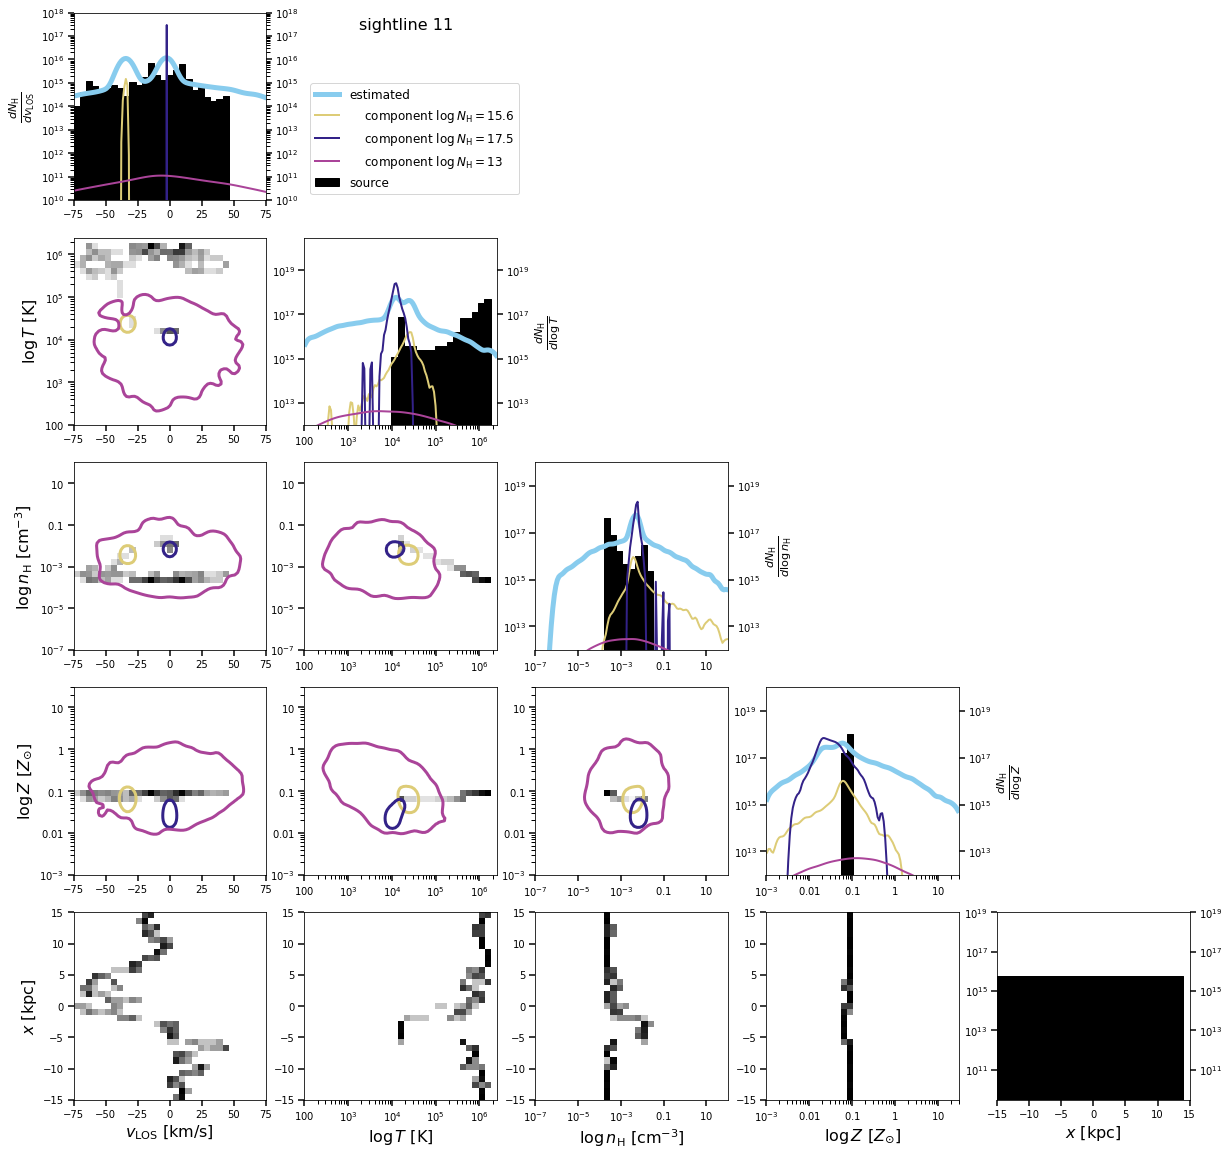

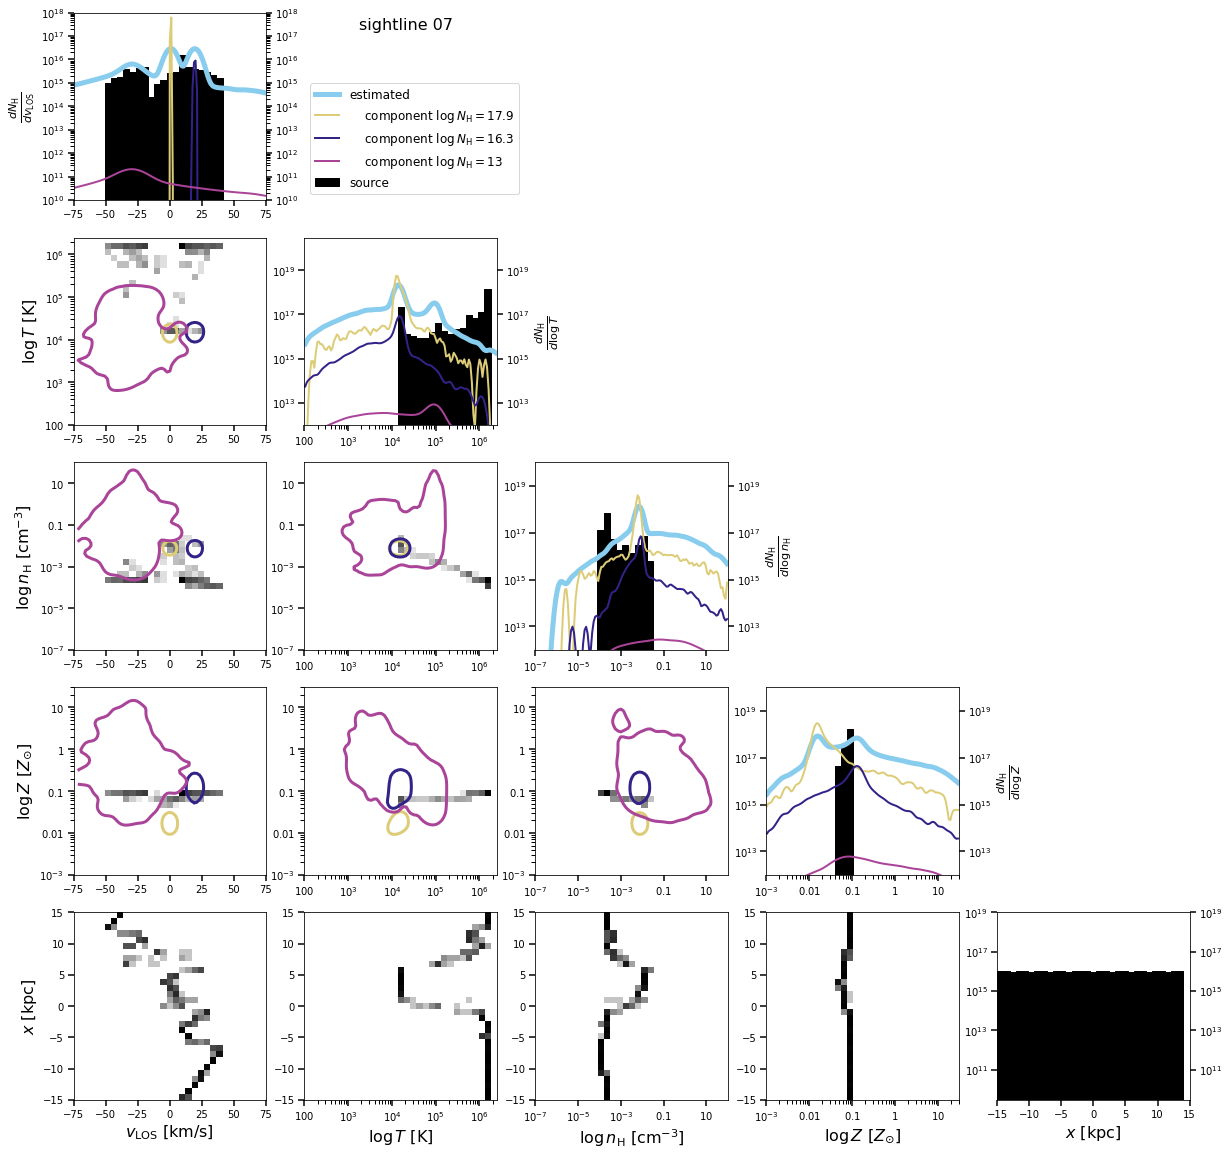

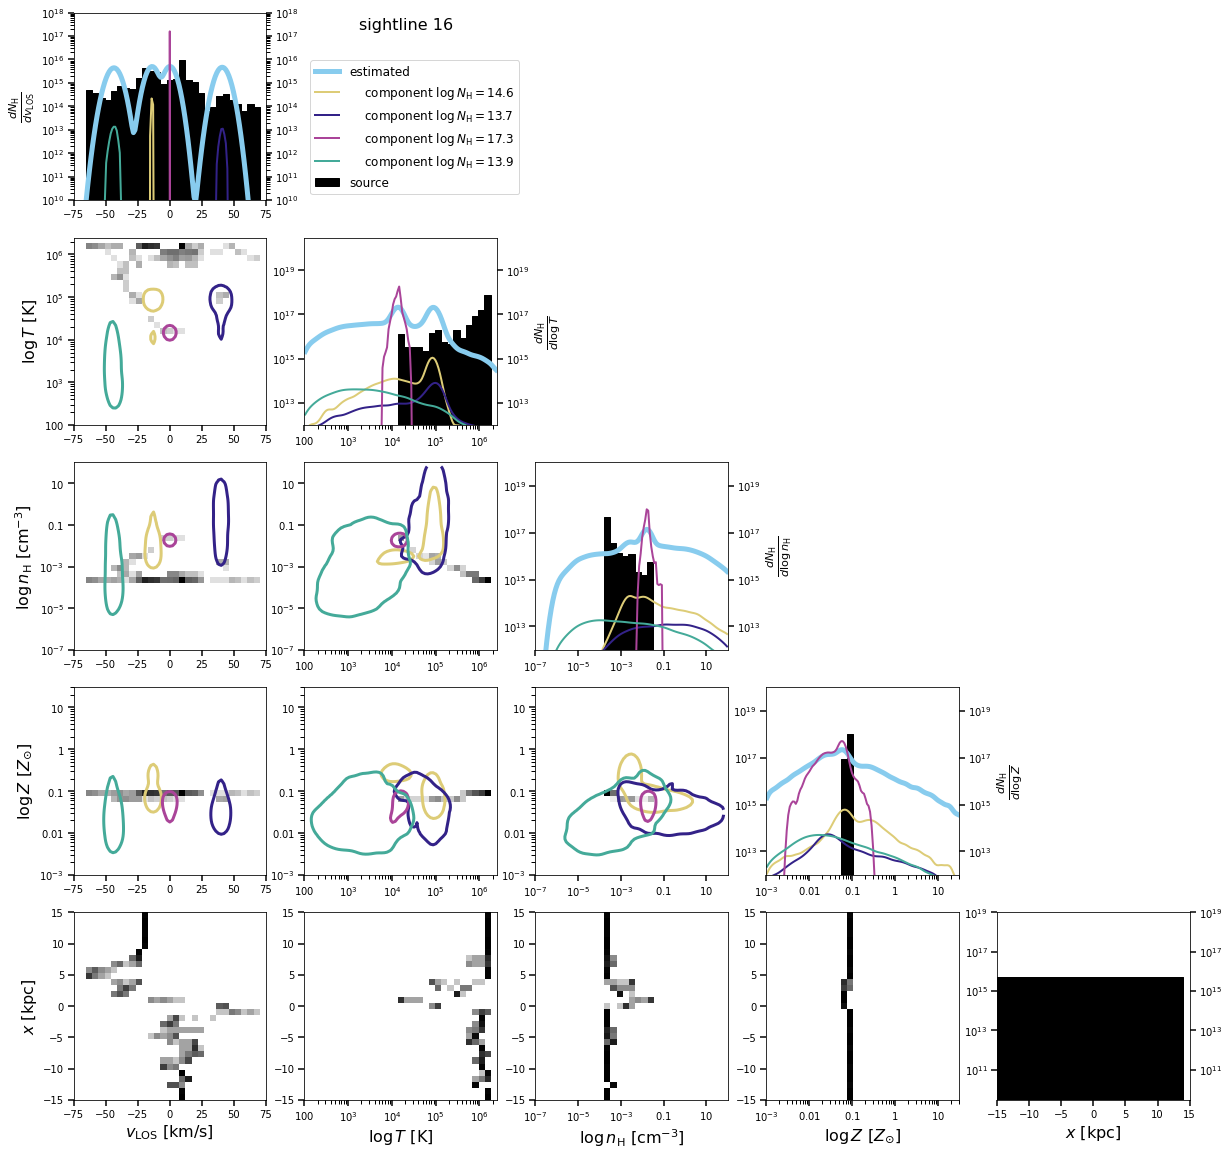

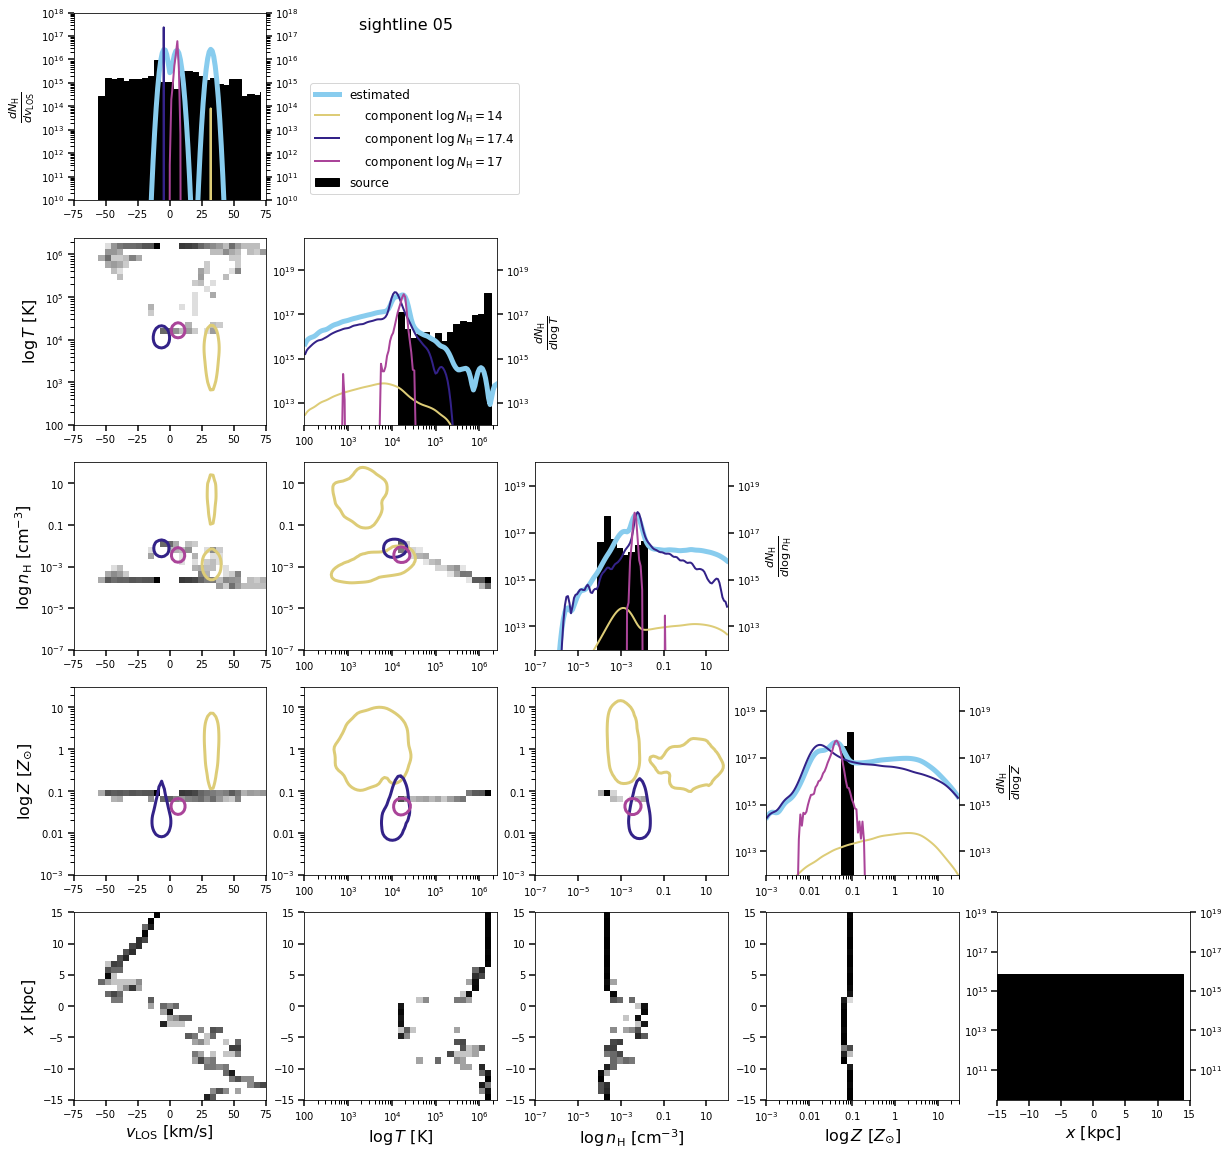

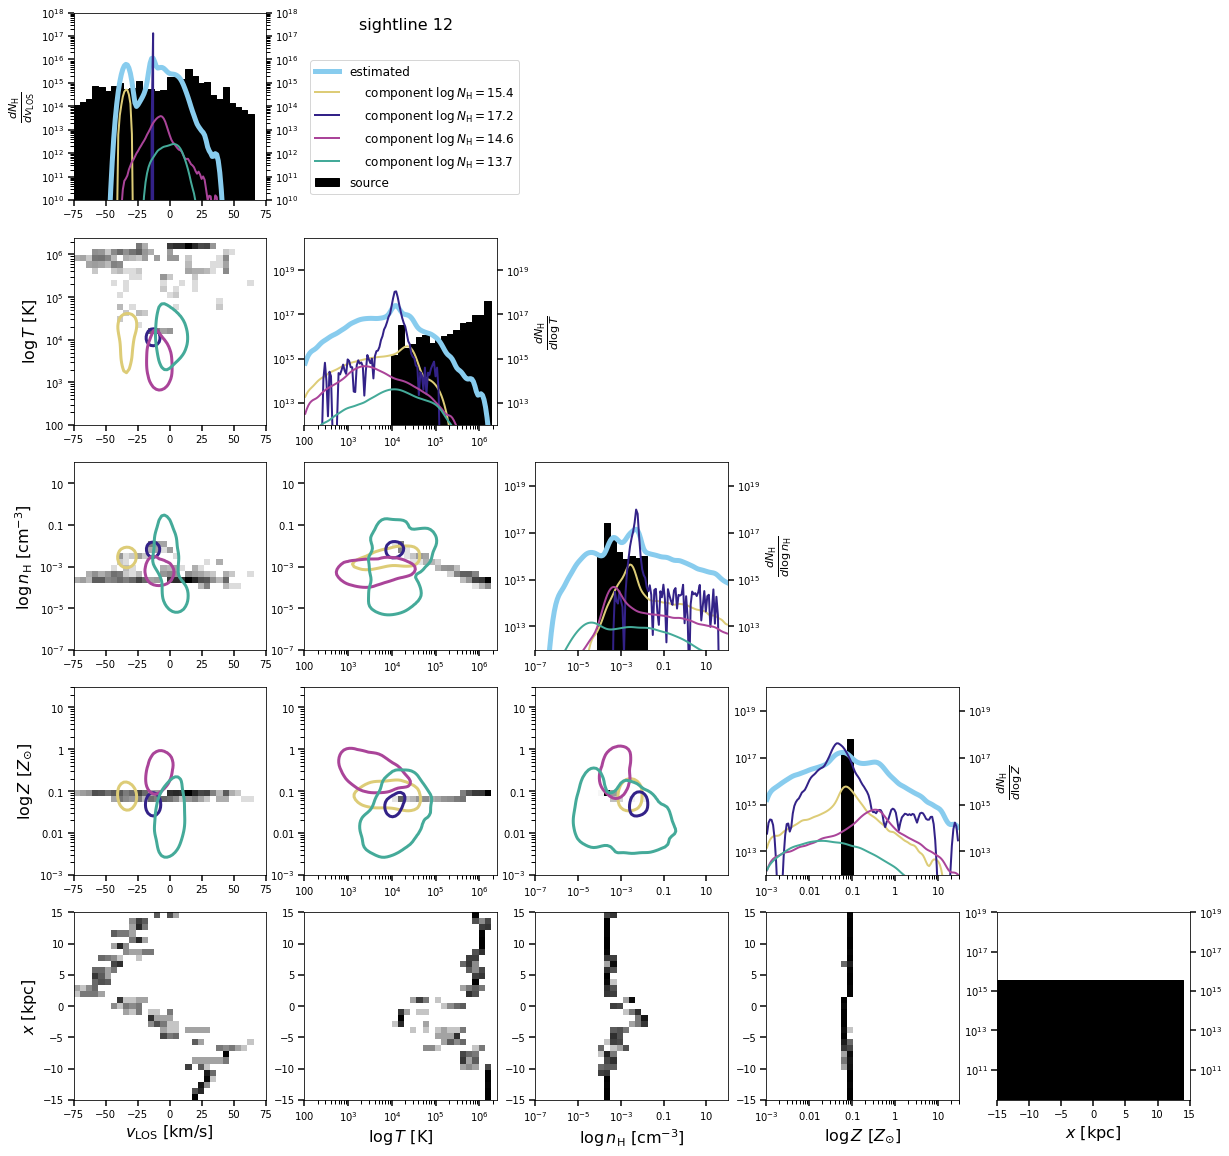

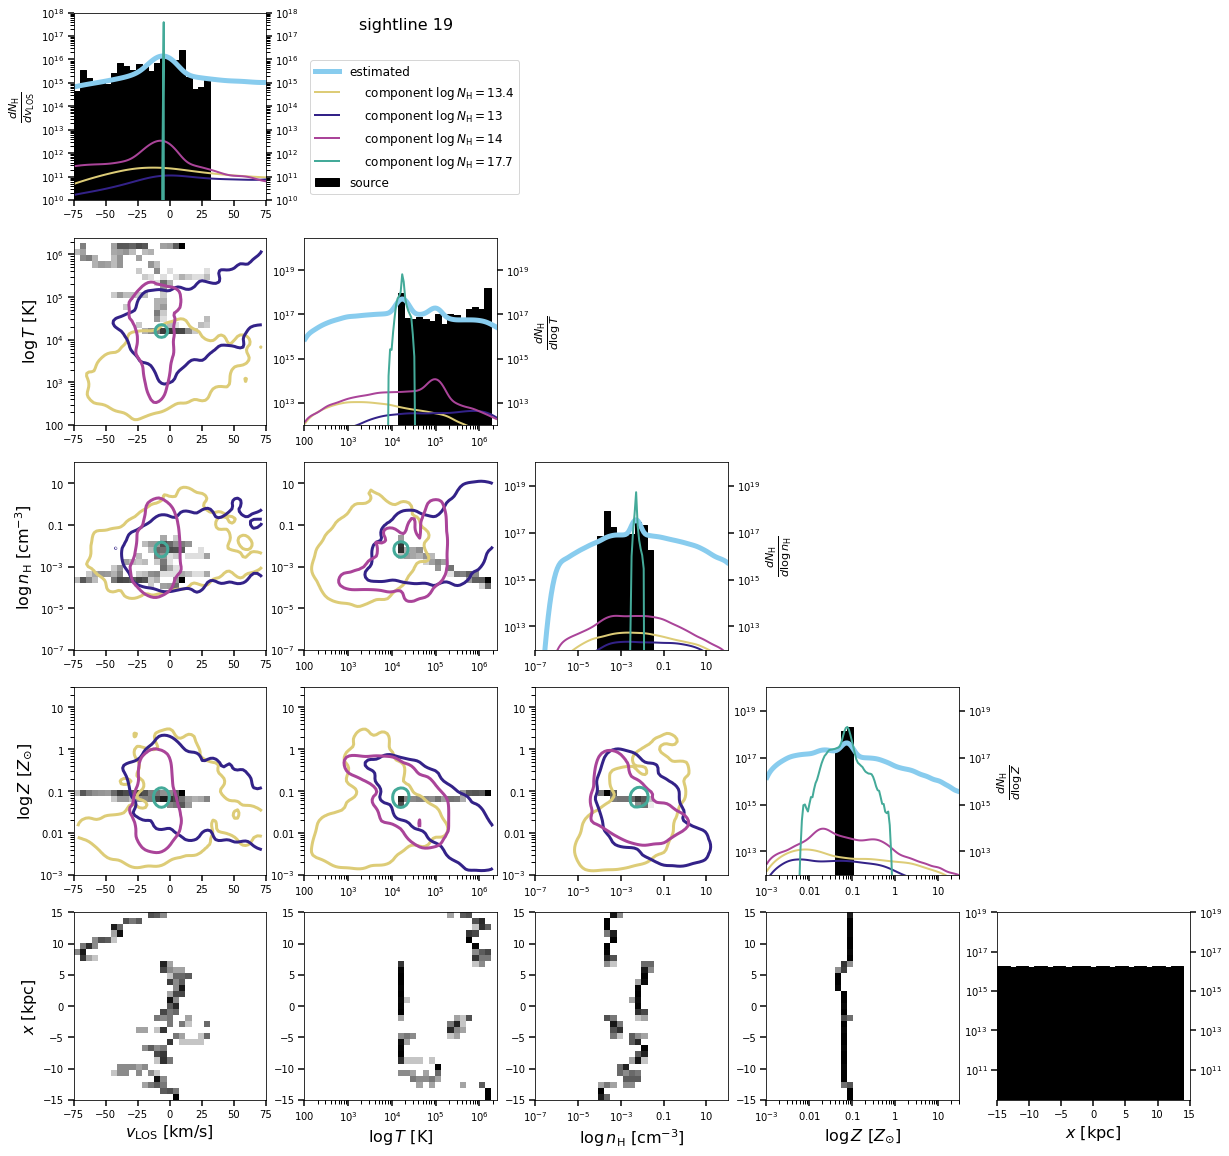

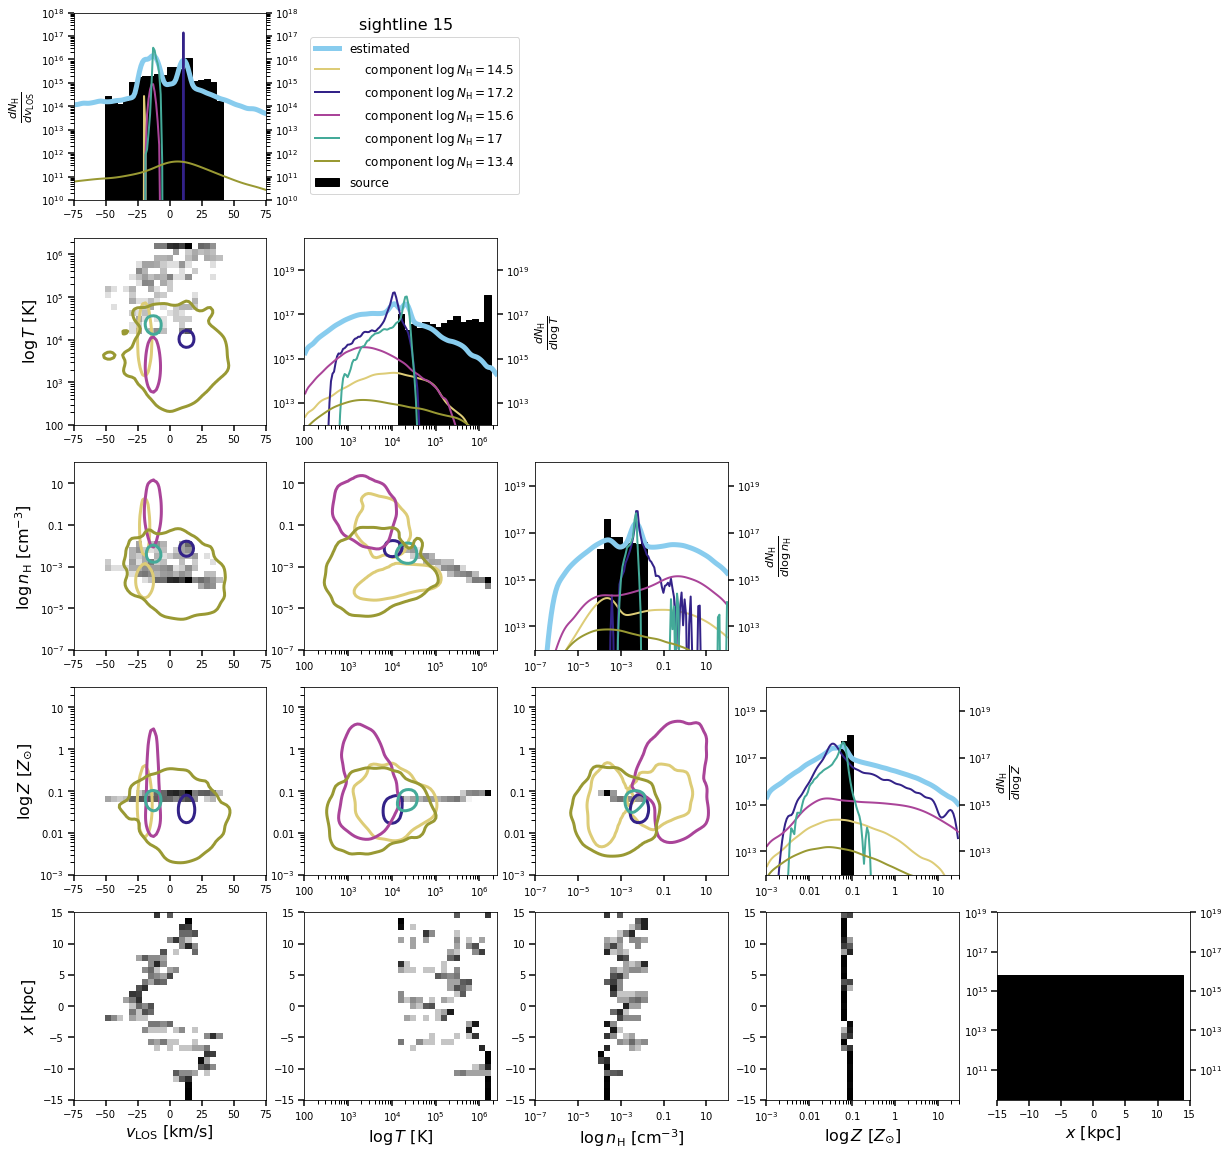

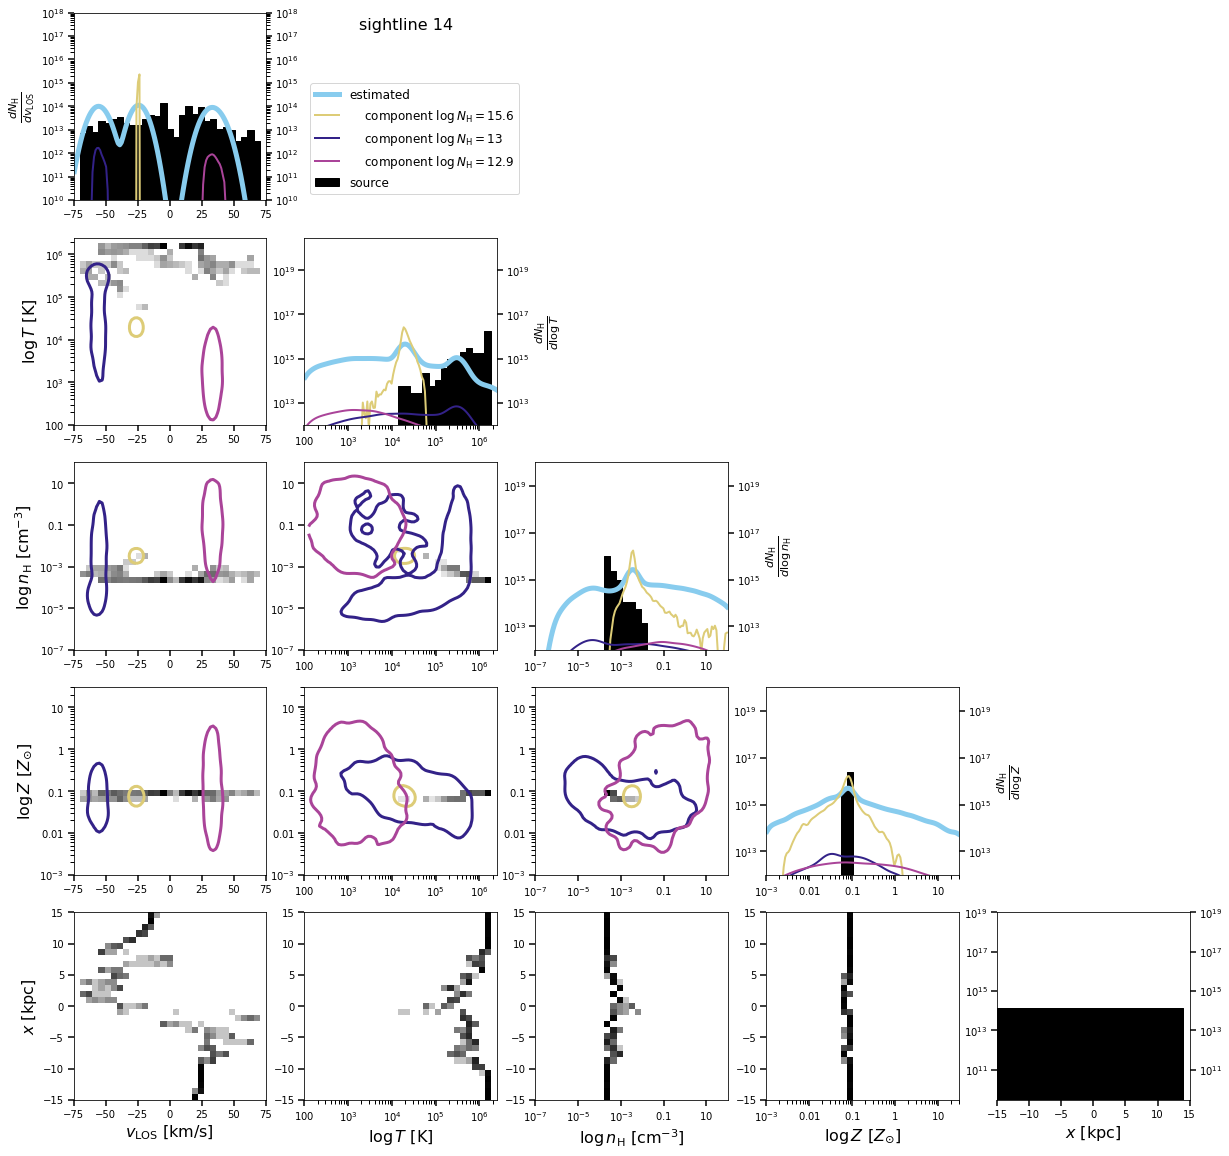

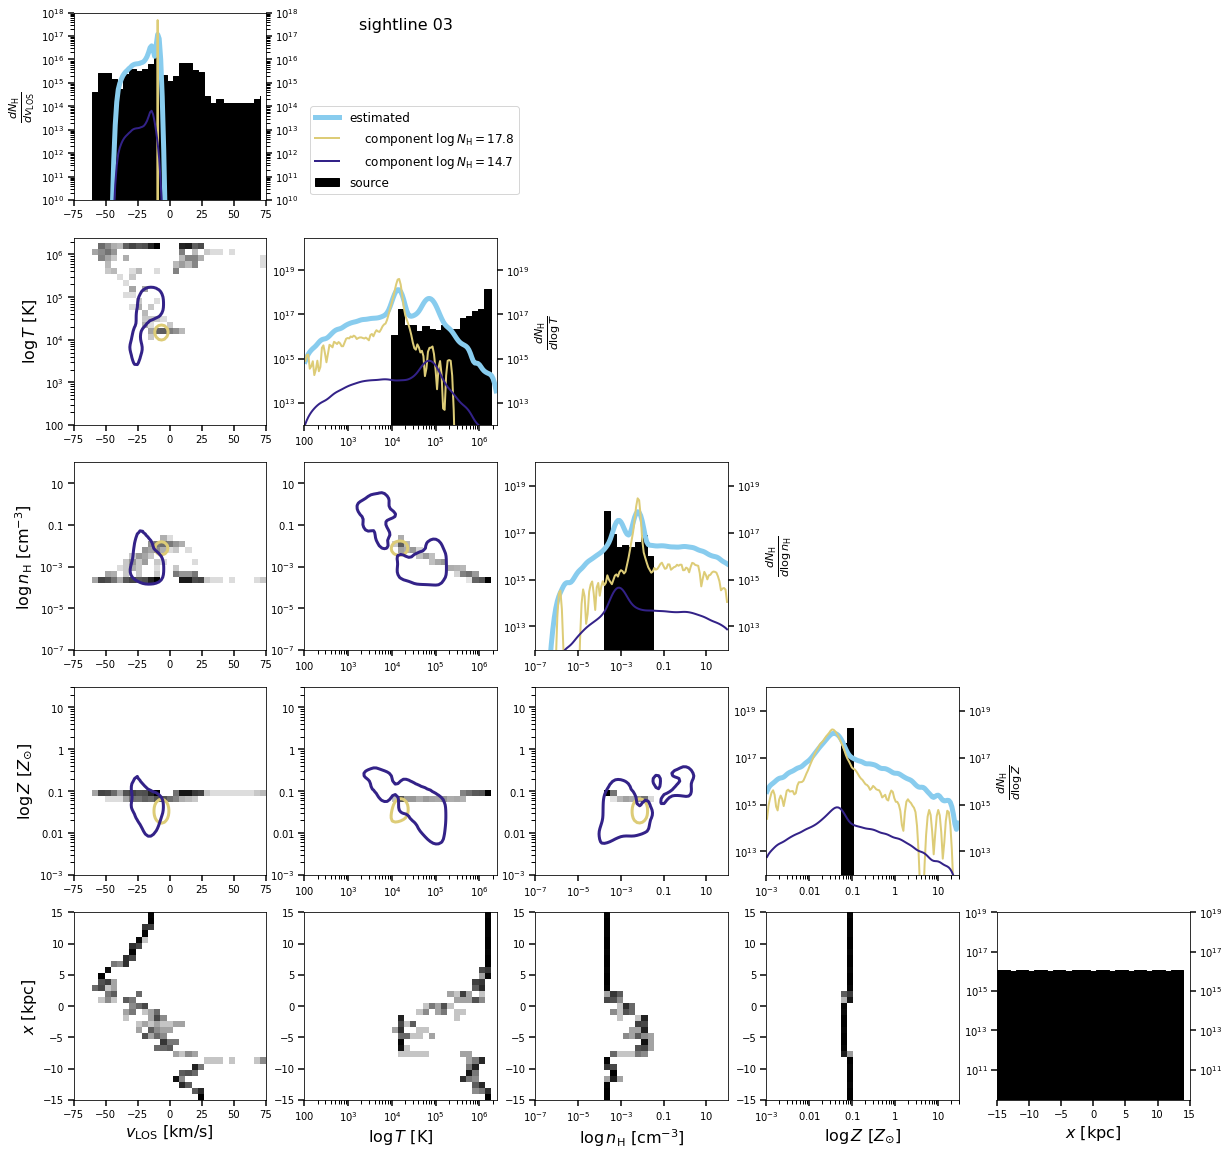

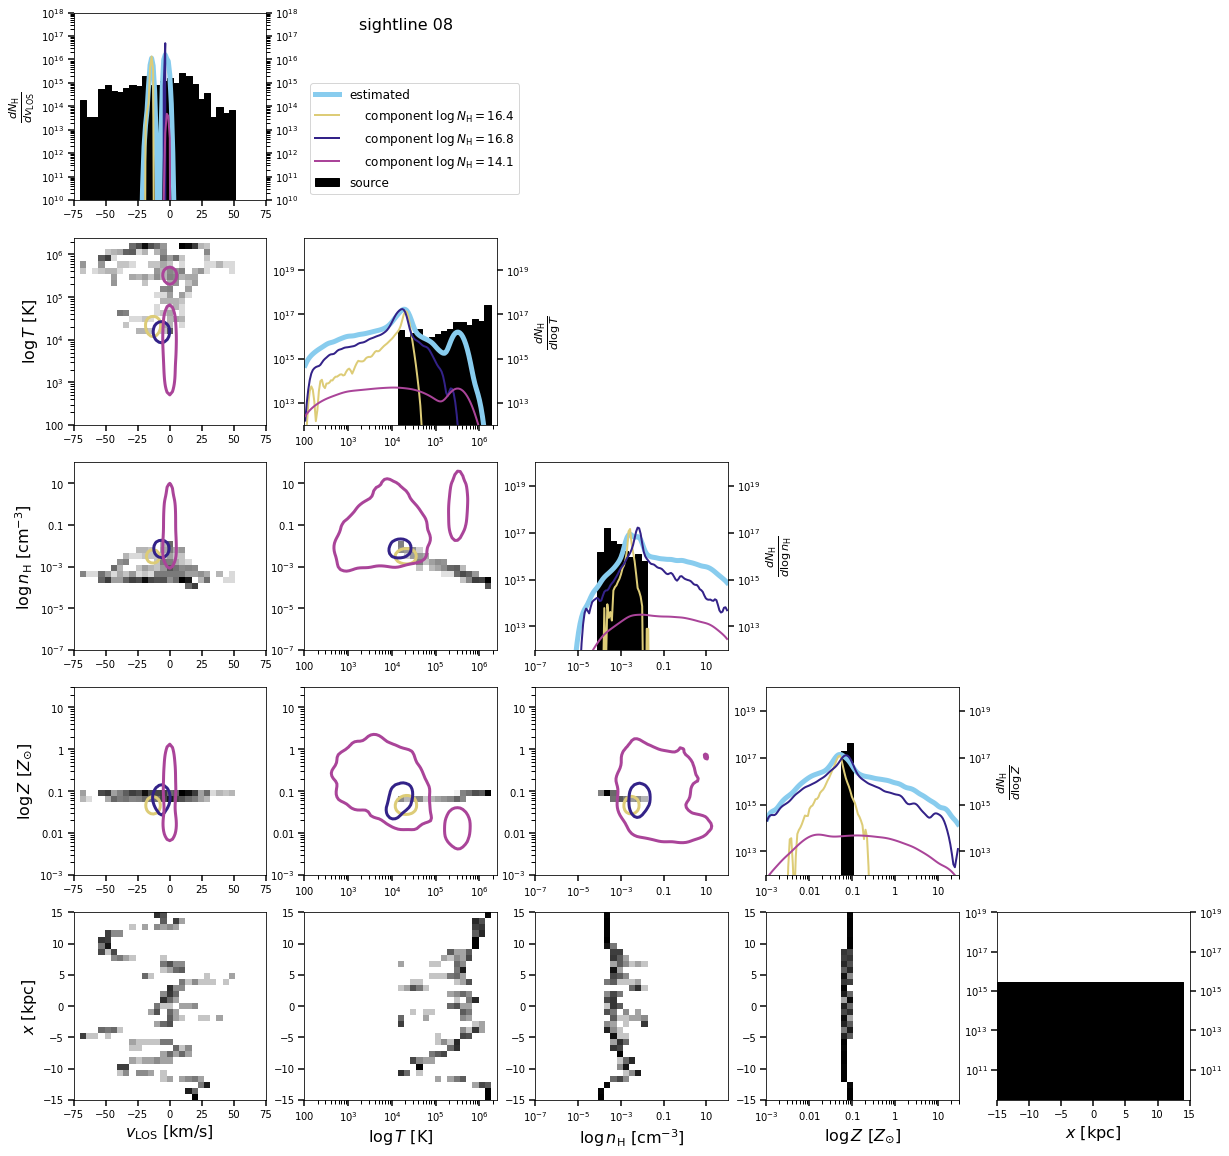

In [49]:
for i, ray in enumerate( rays ):
    
    print( '\nMaking comparison for ray {}\n'.format( i ) )

    ray_data = ray_datas[i]
    weights = ray_weights[i]

    # estimated sightline
    sl_data = sl_datas[i]
    sl_used = sl_useds[i]
    sl_stacked = sl_stackeds[i]
    model_weights = model_weightss[i]
    stacked_weights = stacked_weightss[i]
    total_weights = total_weightss[i]
    median_NHI = median_NHIs[i]
    
    all_bins = all_binss[i]
    all_dx = all_dxs[i]
    all_centers = all_centerss[i]
    
    bins = all_bins['n_bins_1D']
    dx = all_dx['n_bins_1D']
    centers = all_centers['n_bins_1D']
    
    # Setup Figurea
    n_cols = len( prop_keys )
    fig = plt.figure( figsize=( panel_length*n_cols, panel_length*n_cols ), facecolor='w' )
    ax_dict = fig.subplot_mosaic( mosaic )

    # Loop through all properties
    for j, x_key in enumerate( tqdm.tqdm( prop_keys, bar_format=bar_format ) ):
        for k, y_key in enumerate( prop_keys ):

            # Avoid duplicates
            if k < j:
                continue
                
            xy_key = '{}_{}'.format( x_key, y_key )

            # Check for out-of-bounds
            oob_labels = [ 'ray', 'estimated' ]
            for ii, key in enumerate([ x_key, y_key ]):
            
                if key in sl_stacked:
                    values_for_limits = [ ray_data[key], sl_stacked[key] ]
                else:
                    values_for_limits = [ ray_data[key], ]
                    
                weights_for_limits = [ weights, stacked_weights ]
                
                bins_for_limits = bins[key]
                if helpers.logscale[key]:
                    bins_for_limits = np.log10( bins_for_limits )
                
                for jj, values in enumerate( values_for_limits ):
                    
                    if helpers.logscale[key]:
                        values = np.log10( values )
                    else:
                        values = values.value
                    
                    values_weighted = values * weights_for_limits[jj]
                    
                    is_low = values < bins_for_limits[0]
                    sum_low = values_weighted[is_low].sum()
                    is_high = values > bins_for_limits[-1]
                    sum_high = values_weighted[is_high].sum()
                    sum_total = values_weighted.sum()
                    
                    bounds = [ 'below', 'above' ]
                    bools = [ is_low, is_high ]
                    for kk, sum_oob in enumerate([ sum_low, sum_high ]):
                        frac_oob = ( sum_oob / sum_total )
                        if frac_oob > 0.05:
                            warnings.warn(
                                '{} {} points ({:.2g}% of weight) with {} {} {:.3g}'.format(
                                    bools[kk].sum(),
                                    oob_labels[jj],
                                    frac_oob * 100,
                                    key,
                                    bounds[kk],
                                    lims[key][kk],
                                )
                            )

            # 1D histogram
            if j == k:
                ax = ax_dict[x_key]
                subplotspec = ax.get_subplotspec()

                x_label = labels[x_key]
                y_label = labels_1D[x_key]
                
                bins = all_bins['n_bins_1D']
                dx = all_dx['n_bins_1D']
                centers = all_centers['n_bins_1D']

                # Observational
                if x_key in sl_stacked:
                    
                    if pm['1D_dist_estimation'] == 'histogram':
                        hist_o, edges = np.histogram(
                            sl_stacked[x_key],
                            bins = bins[x_key],
                            weights = stacked_weights,
                            density = False,
                        )
                        hist_o /= hist_o.sum() * dx[x_key]
                        ax.step(
                            edges[:-1],
                            hist_o,
                            color = color_estimated,
                            where = 'post',
                            linewidth = 2,
                        )
                    elif pm['1D_dist_estimation'] == 'kde':
                        # Change to logspace for kde
                        if logscale[x_key]:
                            sl_kde = np.log10( sl_stacked[x_key] )
                            kde_centers = np.log10( centers[x_key] )
                        else:
                            sl_kde = sl_stacked[x_key].value
                            kde_centers = centers[x_key].value
                        kde_centers, hist_o = kale.density(
                            sl_kde,
                            points = kde_centers,
                            weights = stacked_weights,
                            probability = False,
                        )
                        hist_o /= hist_o.sum() * dx[x_key]
                        hist_o *= median_NHI.sum()
                        ax.plot(
                            centers[x_key],
                            hist_o,
                            linewidth = 5,
                            color = color_estimated,
                            label = 'estimated',
                        )


                        # Individual components
                        for kk, sl_used_x in enumerate( sl_used[x_key] ):       
                            if logscale[x_key]:
                                sl_used_x = np.log10( sl_used_x )
                            else:
                                sl_used_x = sl_used_x.value
                                
                            kde_centers, hist_o_kk = kale.density(
                                    sl_used_x,
                                    points = kde_centers,
                                    weights = model_weights[kk],
                                    probability = False,
                                )
                            
                            # Check for delta function, which kale can't handle
                            if np.isclose( hist_o_kk.sum(), 0. ):
                                value = np.mean( sl_used_x )
                                hist_o_kk[np.argmin((kde_centers - value)**2.)] = model_weights[kk].sum()
                            
                            hist_o_kk /= hist_o_kk.sum() * dx[x_key]
                            hist_o_kk *= median_NHI[kk]

                            # Cycle through colors, skipping the color reserved for the ray data
                            if kk == 0:
                                cmap_kk = kk
                            else:
                                cmap_kk = kk + 1

                            ax.plot(
                                centers[x_key],
                                hist_o_kk,
                                linewidth = 2,
                                color = cmap[cmap_kk],
                                label = r'    component $\log ' + helpers.weighting_labels[pm['weighting']] + '=$' + '{:.3g}'.format( np.log10( median_NHI[kk] ) ),
                            )

                            # Store data
                            figure_data.setitem( public_label, hist_o_kk, sls[i], 'estimated', '1D distributions', 'individual distributions', sl_compkeys[i][kk], x_key )

                        # Store data
                        figure_data.setitem( public_label, hist_o, sls[i], 'estimated', '1D distributions', 'combined distributions', x_key )
                        figure_data.setitem( public_label, centers[x_key], sls[i], 'estimated', '1D distributions', 'centers', x_key )
                        figure_data.setitem( public_label, bins[x_key], sls[i], 'estimated', '1D distributions', 'bins', x_key )

                # Ray
                bins = all_bins['n_bins_data_1D']
                dx = all_dx['n_bins_data_1D']
                centers = all_centers['n_bins_data_1D']
                
                if pm['1D_dist_estimation_data'] == 'histogram':
                    hist_r, edges = np.histogram(
                        ray_data[x_key],
                        bins = bins[x_key],
                        weights = weights,
                        density = False,
                    )
                    hist_r /= hist_r.sum() * dx[x_key]
                    hist_r *= ray_data['NHI'].sum()
                    ax.fill_between(
                        edges[:-1],
                        hist_r,
                        color = color_data,
                        step = 'post',
                        label = 'source',
                    )
                elif pm['1D_dist_estimation_data'] == 'kde':
                    # Change to logspace for kde
                    if logscale[x_key]:
                        sl_kde = np.log10( ray_data[x_key] )
                        kde_centers = np.log10( centers[x_key] )
                    else:
                        sl_kde = ray_data[x_key].value
                        kde_centers = centers[x_key].value
                    kde_centers, hist_r = kale.density(
                            sl_kde,
                            points = kde_centers,
                            weights = weights,
                            probability = False,
                        )
                    hist_r /= hist_r.sum() * dx[x_key]
                    hist_r *= ray_data['NHI'].sum()
                    ax.fill_between(
                        centers[x_key],
                        hist_r,
                        color = color_data,
                        step = 'mid',
                    )

#                 y_min = 10.**np.nanmin( [ np.nanmin( np.log10( hist_o[hist_o>0] ) ), np.nanmin( np.log10( hist_r[hist_r>0] ) ) ] )
#                 y_min = lims_1D[x_key]
#                 y_max = np.nanmax([ np.nanmax( hist_r ), np.nanmax( hist_o ) ])
#                 ax.set_ylim( y_min, y_max * 1.05 )
                ax.set_ylim( lims_1D[x_key] )
                ax.set_xlim( bins[x_key][0], bins[x_key][-1] )

                if logscale[x_key]:
                    ax.set_xscale( 'log' )
                ax.set_yscale( 'log' )
                
                if x_key in [ 'T', 'nH', 'Z' ]:
                    ax.yaxis.set_label_position( 'right' )
                    ax.set_ylabel( y_label, fontsize=16 )

                ax.tick_params(
                    which = 'both',
                    right = True,
                    labelright = True,
                )
                
                # Save ray data
                figure_data.setitem( public_label, hist_r, sls[i], 'source', '1D distributions', 'distributions', x_key )
                figure_data.setitem( public_label, centers[x_key], sls[i], 'source', '1D distributions', 'centers', x_key )
                figure_data.setitem( public_label, bins[x_key], sls[i], 'source', '1D distributions', 'bins', x_key )

            # 2D histogram
            else:
                
                bins = all_bins['n_bins_2D']
                dx = all_dx['n_bins_2D']
                centers = all_centers['n_bins_2D']
                
                centers_x = copy.copy( centers[x_key] )
                centers_y = copy.copy( centers[y_key] )
                
                try:
                    ax = ax_dict['{}_{}'.format( x_key, y_key )]
                except KeyError:
                    ax = ax_dict['{}_{}'.format( y_key, x_key )]
                subplotspec = ax.get_subplotspec()
                              
                # Upsample centers
                upsample = pm['upsample_2D_dist']
                if upsample is not None:
                    centers_x = scipy.ndimage.zoom( centers_x, upsample )
                    centers_y = scipy.ndimage.zoom( centers_y, upsample )
                
                # Observational per component
                img_arr_comps = []
                    
                if ( x_key in sl_used ) and ( y_key in sl_used ):
                    for kk, sl_used_x in enumerate( sl_used[x_key] ):
                        sl_used_y = sl_used[y_key][kk]
                        norm_kk = total_weights[kk] * dx[x_key] * dx[y_key]

                        # Histogram version
                        if pm['2D_dist_estimation'] == 'histogram':
                            hist2d_kk, x_edges, y_edges = np.histogram2d(
                                sl_used_x,
                                sl_used_y,
                                bins = [ bins[x_key], bins[y_key], ],
                                weights = model_weights[kk] / norm_kk,
                            )
                            img_arr_kk = np.transpose( hist2d_kk )

                        # KDE version
                        elif pm['2D_dist_estimation'] == 'kde':

                            # Change to logspace for kde
                            if logscale[x_key]:
                                sl_used_x = np.log10( sl_used_x )
                                kde_centers_x = np.log10( centers_x )
                            else:
                                kde_centers_x = centers[x_key]
                            if logscale[y_key]:
                                sl_used_y = np.log10( sl_used_y )
                                kde_centers_y = np.log10( centers_y )
                            else:
                                kde_centers_y = centers[y_key]

                            kde_arr = np.array([ sl_used_x, sl_used_y ])
                            points, img_arr_kk = kale.density(
                                kde_arr,
                                points = [ kde_centers_x, kde_centers_y ],
                                grid = True,
                                weights = model_weights[kk] / norm_kk,
                            )

                        # Upsample and smooth
                        if upsample is not None:
                            img_arr_kk = scipy.ndimage.zoom( img_arr_kk, upsample )                                                                                                

                        if pm['smooth_2D_dist'] is not None:
                            if upsample is not None:                                                   
                                sigma = upsample * pm['smooth_2D_dist']
                            else:
                                sigma = pm['smooth_2D_dist']
                            img_arr_kk = scipy.ndimage.gaussian_filter( img_arr_kk, sigma )

                        # Get levels corresponding to percentages enclose
                        c_calc_kk = ContourCalc( img_arr_kk )
                        levels = c_calc_kk.get_level( contour_levels )

                        # Cycle through colors, skipping the color reserved for the ray data
                        if kk == 0:
                            cmap_kk = kk
                        else:
                            cmap_kk = kk + 1
                        contour_colors = [ cmap[cmap_kk], ] * len( levels )

                        # Prevent invisible low-contribution components
                        alpha_min = 0.5
                        contour_alpha = ( total_weights[kk] / total_weights.max() ) * ( 1. - alpha_min ) + alpha_min

                        ax.contour(
                            centers_x,
                            centers_y,
                            img_arr_kk,
                            levels,
                            colors = contour_colors,
                            linewidths = contour_linewidths,
                            alpha = contour_alpha
                        )

                        # Store data
                        figure_data.setitem( public_label, img_arr_kk, sls[i], 'estimated', '2D distributions', 'component distributions', sl_compkeys[i][kk], xy_key  )
                        figure_data.setitem( public_label, levels, sls[i], 'estimated', '2D distributions', 'levels', xy_key )
                        figure_data.setitem( public_label, contour_alpha, sls[i], 'estimated', '2D distributions', 'alpha', xy_key )
                    figure_data.setitem( public_label, centers_x, sls[i], 'estimated', '2D distributions', 'x centers', x_key )
                    figure_data.setitem( public_label, centers_y, sls[i], 'estimated', '2D distributions', 'y centers', y_key )
                    figure_data.setitem( public_label, bins[x_key], sls[i], 'estimated', '2D distributions', 'x bins', x_key )
                    figure_data.setitem( public_label, bins[y_key], sls[i], 'estimated', '2D distributions', 'y bins', y_key )
                    
                # Source data
                bins = all_bins['n_bins_data_2D']
                dx = all_dx['n_bins_data_2D']
                centers = all_centers['n_bins_data_2D']
                centers_x = centers[x_key]
                centers_y = centers[y_key]
                
                hist2d_r, x_edges, y_edges = np.histogram2d(
                    ray_data[x_key],
                    ray_data[y_key],
                    bins = [ bins[x_key], bins[y_key], ],
                    weights = weights,
                )
                hist2d_r /= dx[x_key] * dx[y_key]
                img_arr_r = np.transpose( hist2d_r )
                
                if pm['2D_dist_data_display'] == 'histogram':
                    ax.pcolormesh(
                        centers_x,
                        centers_y,
                        img_arr_r,
                        cmap = cmap_data,
                        shading = 'nearest',
                        norm = matplotlib.colors.LogNorm(),
                    )
                elif pm['2D_dist_data_display'] == 'contour':
                    
                    centers_x = copy.copy( centers_x )
                    centers_y = copy.copy( centers_x )

                    # Upsample and smooth
                    if upsample is not None:
                        img_arr_r = scipy.ndimage.zoom( img_arr_r, upsample )
                        
                        centers_x = scipy.ndimage.zoom( centers_x, upsample )
                        centers_x = scipy.ndimage.zoom( centers_x, upsample )

                    if pm['smooth_2D_dist'] is not None:
                        if upsample is not None:                                                   
                            sigma = upsample * pm['smooth_2D_dist']
                        else:
                            sigma = pm['smooth_2D_dist']
                        img_arr_r = scipy.ndimage.filters.gaussian_filter( img_arr_r, sigma )

                    # Get levels corresponding to percentages enclose
                    c_calc_kk = ContourCalc( img_arr_r )
                    levels = c_calc_kk.get_level( contour_levels + [ -1, ], False )
                    
                    ax.contourf(
                        centers_x,
                        centers_y,
                        img_arr_r,
                        levels,
                        cmap = cmap_data,
                        zorder = -100,
                    )
                    
                figure_data.setitem( public_label, img_arr_r, sls[i], 'source', '2D distributions', 'distribution', xy_key  )
                figure_data.setitem( public_label, levels, sls[i], 'source', '2D distributions', 'levels', xy_key )
                figure_data.setitem( public_label, centers_x, sls[i], 'source', '2D distributions', 'x centers', x_key )
                figure_data.setitem( public_label, centers_y, sls[i], 'source', '2D distributions', 'y centers', y_key )
                figure_data.setitem( public_label, bins[x_key], sls[i], 'source', '2D distributions', 'x bins', x_key )
                figure_data.setitem( public_label, bins[y_key], sls[i], 'source', '2D distributions', 'y bins', y_key )

                ax.set_xlim( bins[x_key][0], bins[x_key][-1] )
                ax.set_ylim( bins[y_key][0], bins[y_key][-1] )

                if logscale[x_key]:
                    ax.set_xscale( 'log' )
                if logscale[y_key]:
                    ax.set_yscale( 'log' )

                x_label = labels[x_key]
                y_label = labels[y_key]

            if subplotspec.is_last_row():
                ax.set_xlabel( x_label, fontsize=16 )
            if subplotspec.is_first_col():
                ax.set_ylabel( y_label, fontsize=16 )
                
            # Correlation coefficient annotation
            if calc_correlations:
                coeff = correlations['log']['matrix'][sls[i]][j,k]
                text = r'$r =$' + '{:.2f}'.format( coeff ) 
                annot = ax.annotate(
                    text = text,
                    xy = ( 1, 1 ),
                    xycoords = 'axes fraction',
                    xytext = ( -5, -5 ),
                    textcoords = 'offset points',
                    va = 'top',
                    ha = 'right',
                    fontsize = 14,
                    color = 'w',
                )
                coeff_color = corr_cmap( corr_norm( coeff ) )
                annot.set_path_effects([
                    path_effects.Stroke( linewidth=3, foreground=coeff_color ),
                    path_effects.Normal()
                ])
                
    # Add a legend
    h, l = ax_dict['vlos'].get_legend_handles_labels()
    ax_dict['legend'].legend( h, l, loc='lower left', prop={'size': 12}, )
    ax_dict['legend'].axis( 'off' )
    
    # Ray number
    annot = ax_dict['legend'].annotate(
        text = 'sightline {}'.format( sls[i][-2:] ),
        xy = ( 0.5, 1 ),
        xycoords = 'axes fraction',
        xytext = ( 5, -5 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'center',
        fontsize = 16,
        color = 'k',
    )

    # Save
    savedir = os.path.join( pm['data_dir'], 'figures' )
    os.makedirs( savedir, exist_ok=True )
    savefile = 'sightline_{}.png'.format( os.path.basename( sls[i] ) )
    save_fp = os.path.join( savedir, savefile )
    print( 'Saving figure to {}'.format( save_fp ) )
    plt.savefig( save_fp, bbox_inches='tight', dpi=150 )
    
    if not pm['show_plots_in_nb']:
        plt.close()

In [50]:
# Save data
if pm['global_variation'] == '':
    figure_data.to_hdf5( figure_data_fp )